## Import libraries

In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect with AWS
from sqlalchemy import create_engine

# Modeling functions
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn import tree

# Built modules
import sys
sys.path.append('/Users/laurengilson/laurenhoward_github')
from modeling_funcs import *

# Jupyter Formatting
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Connect database for queries

In [ ]:
connection = create_engine('postgresql://ubuntu:@18.225.36.12:5432/wine') #IP address changes - check EC2 instance
pd.read_sql_query('''SELECT * FROM winetable LIMIT 5;''', connection)

## Cleaning and EDA

### Tidy and make ML friendly

In [30]:
# Read .csv file of data
wine = pd.read_csv('/Users/laurengilson/metis_bootcamp/Projects/project3_mcnulty/winequality.csv')

In [31]:
# Remove Quality and Good columns - these are subjective from original dataset use - not attributes of each wine. 
wine.drop(wine[["quality","good"]], axis=1, inplace=True)

In [32]:
# Create predictor column (Y) and drop text column of wine colors: 
def wine_color(color):
    '''Creates predictor value for wine color.
    White = 0
    Red = 1'''
    
    if color == 'white':
        return 0
    if color == 'red':
        return 1

wine["predictor"] = wine["color"].apply(wine_color)
wine.drop("color", axis=1, inplace=True)

In [33]:
# Replace white space in column names with underscores
wine.columns = wine.columns.str.replace(' ', '_')

In [34]:
# Create feature of percentage of sulphur dioxide is free
wine["free_percentage"] = ((wine["free_sulfur_dioxide"]/wine["total_sulfur_dioxide"])*100).round(2)

In [35]:
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,predictor,free_percentage
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,32.35
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,37.31
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,27.78
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,28.33
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,32.35


In [36]:
wine.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,predictor,free_percentage
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.246114,28.676728
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.430779,12.464543
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000,2.270000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000,20.210000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,0.000000,26.980000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,0.000000,34.880000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000,85.710000


### Check Data Imbalance

In [37]:
print(f" White Wine Samples: {((wine.predictor.value_counts()[0]/wine.predictor.count())*100).round(2)}%")
print(f" Red Wine Samples: {((wine.predictor.value_counts()[1]/wine.predictor.count())*100).round(2)}%")

 White Wine Samples: 75.39%
 Red Wine Samples: 24.61%


- Keep imbalance for now, re-evaluate later if models don't perform too well.

### Check features

- Compare means of each feature against predictor
- Gives an idea of any features that are significantly different for each type of wine

In [38]:
wine.groupby('predictor').mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_percentage
predictor,,,,,,,,,,,,
0,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,25.557613
1,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,38.231088


**Observations:**  
- Red tends to have higher fixed acidity, higher percentage of free sulphur dioxide, higher sulphates
- White has higher residual sugar, free & total sulphur dioxide 

- Check each feature against the predictor column - to check if any features are strongly correlated with wine colour

fixed_acidity


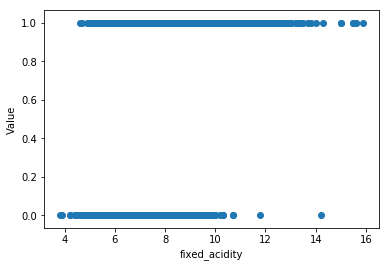

volatile_acidity


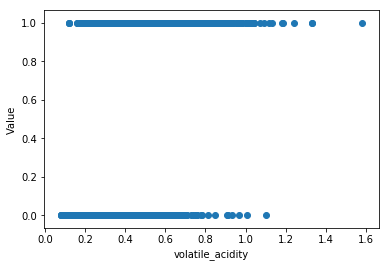

citric_acid


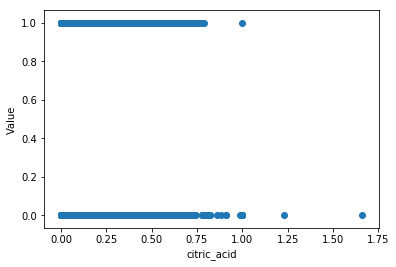

residual_sugar


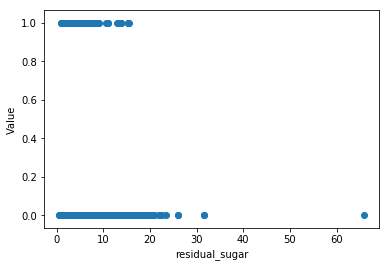

chlorides


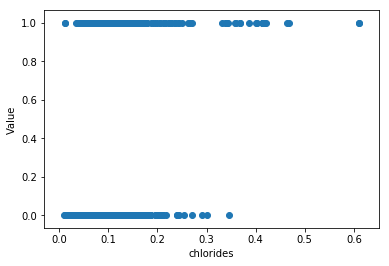

free_sulfur_dioxide


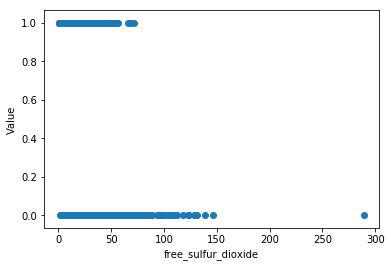

total_sulfur_dioxide


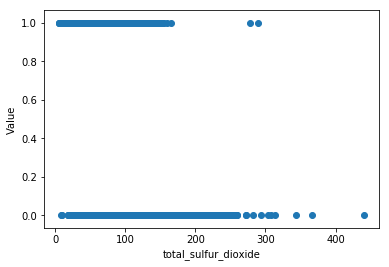

density


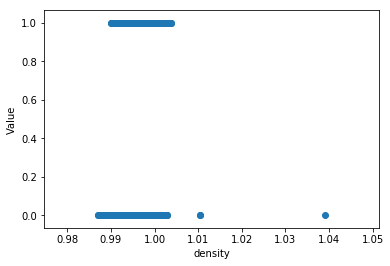

pH


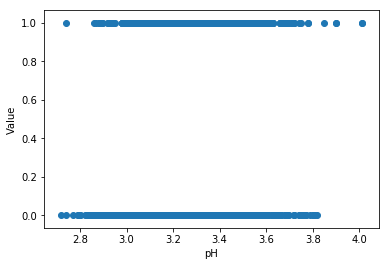

sulphates


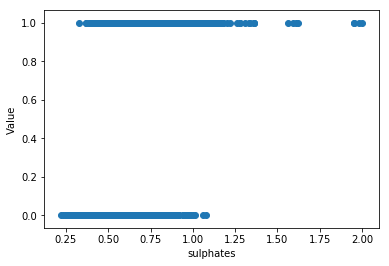

alcohol


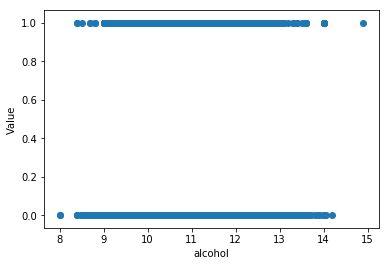

predictor


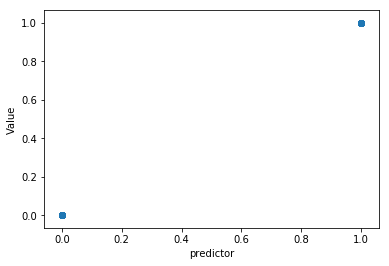

free_percentage


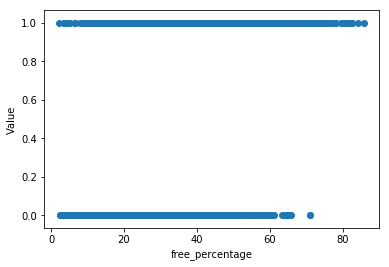

In [39]:
for column in list(wine.columns):
    print(column)
    plt.scatter(wine[column], wine["predictor"])
    plt.xlabel(f"{column}")
    plt.ylabel("Value")
    plt.show()

**Observations**:
- No total distinctions between features
- Some tend to have higher values dependent on the wine e.g. red higher chlorides and white higher residual sugar

**Plot particular features against each other into categories:**

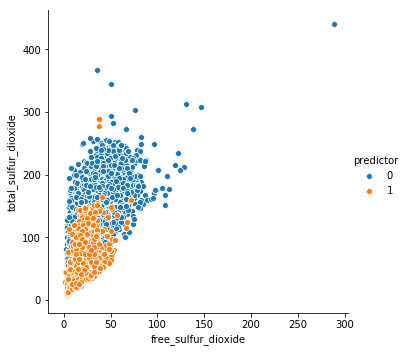

In [40]:
# Free Sulphur Dioxide vs Total Sulphur Dioxide
sns.pairplot(x_vars=["free_sulfur_dioxide"], y_vars=["total_sulfur_dioxide"], data=wine, hue="predictor", size=5);

**Observations:**
- Red tends to have lower free and total sulphur dioxide than white.
- Percentage of free sulphur therefore lower in white
- Doesn't completely separate red and white

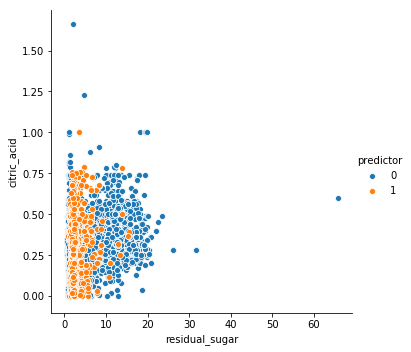

In [41]:
# Residual Sugar and Citric Acid
sns.pairplot(x_vars=["residual_sugar"], y_vars=["citric_acid"], data=wine, hue="predictor", size=5);

**Observations**: 
- Red tends to have lower residual sugars than white. 
- Citric acid tends to be around same value for both, some higher values in the whites

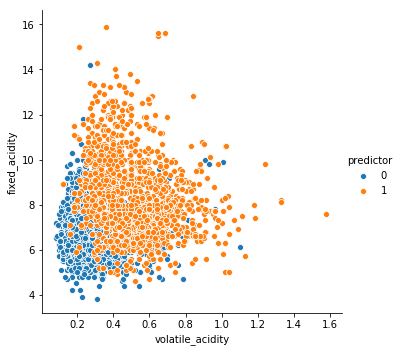

In [42]:
# Fixed acidity vs Volatile activity
sns.pairplot(x_vars=["volatile_acidity"], y_vars=["fixed_acidity"], data=wine, hue="predictor", size=5);

**Observations**:
- White tends to have lower fixed and volatile acidity
- No clear divide - more clusters

**Summary:**  
White: Higher Residual Sugar, Lower total & free sulphur dioxide, Lower fixed & volatile acidity

## Split Data

Split into 80% Training Data and 20% hold out data to test once models are tuned

In [43]:
# initialize random state to be used throughout for consistency
rs = 14

In [44]:
X = wine.drop('predictor', axis=1)
y = wine['predictor']
X_total_train, X_hold_out, y_total_train, y_hold_out = train_test_split(X, y, test_size=.20, random_state=rs)

Check stratified sampling - to make sure there's the correct proprtion of red and white in the training sample

In [45]:
print(f" White Wine Samples (Train): {((y_total_train.value_counts()[0]/y_total_train.count())*100).round(2)}%")
print(f" Red Wine Samples (Train): {((y_total_train.value_counts()[1]/y_total_train.count())*100).round(2)}%")

 White Wine Samples (Train): 75.56%
 Red Wine Samples (Train): 24.44%


In [46]:
print(f" White Wine Samples (Hold out): {((y_hold_out.value_counts()[0]/y_hold_out.count())*100).round(2)}%")
print(f" Red Wine Samples (Hold out): {((y_hold_out.value_counts()[1]/y_hold_out.count())*100).round(2)}%")

 White Wine Samples (Hold out): 74.69%
 Red Wine Samples (Hold out): 25.31%


Further split training data in 80% train and 20% validation

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_total_train, y_total_train, test_size=.20, random_state=rs)

In [48]:
print(f"""Total Splits: 

Training Data:      {len(y_train)} values, {round(len(y_train)/len(wine)*100, 2)}% of dataset
Validation Data:    {len(y_val)} values, {round((len(y_val)/len(wine))*100, 2)}% of dataset
Hold Out Test Data: {len(y_hold_out)} values, {round((len(y_hold_out)/len(wine))*100, 2)}% of dataset""")

Total Splits: 

Training Data:      4157 values, 63.98% of dataset
Validation Data:    1040 values, 16.01% of dataset
Hold Out Test Data: 1300 values, 20.01% of dataset


## Modeling

- Before modelling - want to initialise 3 empty lists to fill throughout.
- ```model_name:``` recording the model 
- ```incorrect_predictions:``` number of incorrect predictions for each model. 
- ```list_of_incorrects:``` lists of incorrect predictions to assess whether there are consistently incorrect predictions
- Then later assess the best models

In [49]:
model_name = []
incorrect_predictions = []
list_of_incorrects = []

### Logistic Regression - Use all features
- Using Log Reg as base model with all the features in the dataset. 
- Log Reg is simple to work from

In [50]:
# Log Reg on train and validation data
lr = LogisticRegression(random_state=rs).fit(X_train, y_train)
lr_predprob = lr.predict_proba(X_val)
lr_pred = lr.predict(X_val)

# Log Reg with Cross Validation
lr_cv = LogisticRegressionCV(random_state=rs).fit(X_train, y_train)
lr_cv_predprob = lr_cv.predict_proba(X_val)
lr_cv_pred= lr_cv.predict(X_val)

In [51]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val, lr_pred, X_train, y_train)

'Accuracy: 0.982 CV:0.988\n    Precision: 0.979 CV:0.983\n    Recall: 0.943 CV:0.969\n    F1: 0.961 CV: 0.976'

ROC AUC score =  0.9930974978429679


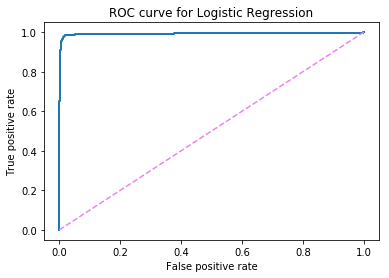

In [52]:
roc_auc(lr, "Logistic Regression", y_val, X_val)

ROC AUC score =  0.9933987165021875


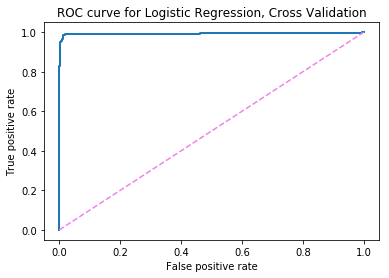

In [53]:
roc_auc(lr_cv, "Logistic Regression, Cross Validation", y_val, X_val)

<Figure size 720x504 with 0 Axes>

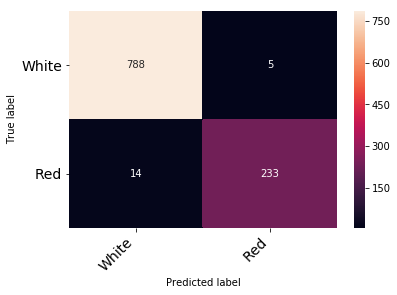

<Figure size 720x504 with 0 Axes>

In [54]:
#Confusion matrix for whole training and val in training set
lr_cm = confusion_matrix(y_val, lr_pred)
print_confusion_matrix(lr_cm)

**Observations**:
- Error metrics, seem to be doing pretty well, use decision trees to find the best features that are used.
- Only predicting 19/1040 incorrectly

In [59]:
append_to_lists(y_val, lr_pred, lr_predprob, "Log Reg, all features")

### Decision Trees - All features
- Run Decision Tree model to see if there's an improvement on classification and evaluate feature importances to tune models

In [60]:
dtc = tree.DecisionTreeClassifier(random_state=rs).fit(X_train, y_train)
y_pred_dtc_prob = dtc.predict_proba(X_val)
y_pred_dtc = dtc.predict(X_val)

In [61]:
ModelErrors(dtc, X_train, y_train, 'Decision Tree')

Decision Tree Av Accuracy: 0.983
Decision Tree Av Precision: 0.968
Decision Tree Av Recall: 0.963
Decision Tree Av F1: 0.965


ROC AUC score =  0.9714276232826707


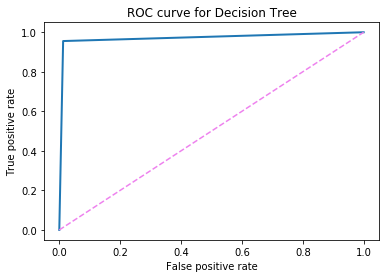

In [62]:
roc_auc(dtc, "Decision Tree", y_val, X_val)

<Figure size 720x504 with 0 Axes>

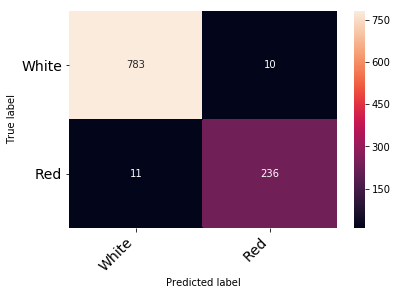

<Figure size 720x504 with 0 Axes>

In [63]:
dtc_cm = confusion_matrix(y_val, y_pred_dtc)
print_confusion_matrix(dtc_cm)

**Observations:**
- Number of white false predictions has increased by 5, however correctly predicts 3 more red correctly 
- ROC AUC still good, however not as good as Logistic Regression

In [64]:
append_to_lists(y_val, y_pred_dtc, y_pred_dtc_prob, "Decision Tree, all features")

In [65]:
# Get feature importance and create dictionary
features = list(dtc.feature_importances_.round(3))
column_names = list(wine.columns.drop('predictor'))

# Sort dictionary so most important features appear first for clarity
importance = dict(zip(column_names, features))
sorted_importance = {k: v for k, v in sorted(importance.items(), key=lambda x: x[1], reverse=True)}

In [66]:
sorted_importance

{'total_sulfur_dioxide': 0.68,
 'chlorides': 0.2,
 'fixed_acidity': 0.043,
 'sulphates': 0.024,
 'volatile_acidity': 0.018,
 'density': 0.014,
 'free_percentage': 0.005,
 'residual_sugar': 0.004,
 'alcohol': 0.004,
 'pH': 0.003,
 'free_sulfur_dioxide': 0.002,
 'citric_acid': 0.001}

**Observations:**
- Two most important features are total_sulphur_dioxide and chlorides
- Least important features: citric_acid and free_sulphur_dioxide

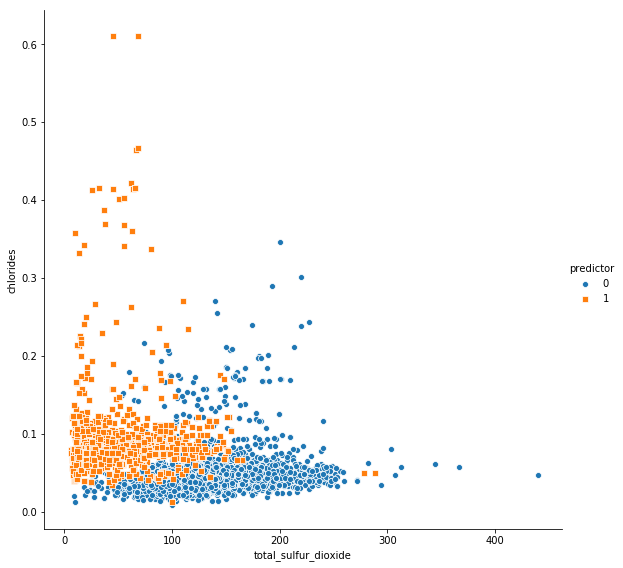

In [67]:
# plot against each other to assess correlation with wine sample colour
sns.pairplot(x_vars=["total_sulfur_dioxide"], y_vars=["chlorides"], data=wine, hue="predictor", markers=["o", "s"], size=8);

**Observations:**
- Red (1) tend to have less sulphur dioxide and higher chlorides 
- White (0) Higher range of total sulphur dioxides and lower chlorides
- Seems to be a fair distinction between red and white in just these features

### Logistic Regression with 2 most important features
- Run Logistic Regression to see if the model performs well with just top features as they seem highly correlated with wine colour

In [68]:
# Re-define data & split - to avoid overriding of other variables
X_2 = wine[['total_sulfur_dioxide', 'chlorides']]
y_2 = wine['predictor']

X_train_2, X_hold_out_2, y_train_2, y_hold_out_2 = train_test_split(X_2, y_2, test_size=.20, random_state=rs)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_train_2, y_train_2, test_size=.20, random_state=rs)

In [70]:
# Logistic Regression and Cross Val Scores
lr2 = LogisticRegression(random_state=rs).fit(X_train_2, y_train_2)
lr_predprob2 = lr2.predict_proba(X_val_2)
lr_pred2 = lr2.predict(X_val_2)

lr_cv_2 = LogisticRegressionCV(random_state=rs).fit(X_train_2, y_train_2)
lr_cv_predprob_2 = lr_cv_2.predict_proba(X_val_2)
lr_cv_pred_2 = lr_cv_2.predict(X_val_2)

In [71]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val_2, lr_pred2, X_train_2, y_train_2)

'Accuracy: 0.932 CV:0.952\n    Precision: 0.904 CV:0.922\n    Recall: 0.798 CV:0.882\n    F1: 0.847 CV: 0.901'

ROC AUC score =  0.9742560154387326


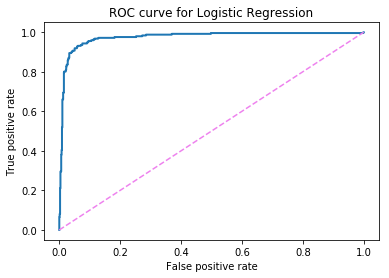

In [72]:
roc_auc(lr_cv_2, "Logistic Regression", y_val_2, X_val_2)

<Figure size 720x504 with 0 Axes>

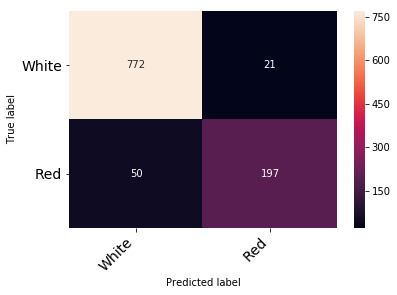

<Figure size 720x504 with 0 Axes>

In [73]:
lr2_cm = confusion_matrix(y_val_2, lr_pred2)
print_confusion_matrix(lr2_cm)

**Observations:**
- Error metrics are lower
- Incorrectly predicting more wines - suggests that the other features are also important in prediction.
- Therefore, going to try more features

In [75]:
append_to_lists(y_val_2, lr_pred2, lr_predprob2, "Logistic Regression, Top 2 features")

### Logistic Regression with more features (importance >1%)
- Going to try with features that have greater than 1% importance from original decision trees 

In [76]:
# Assess importance and return features with 1%+ importance
most_important = [k for k,v in importance.items() if v >= 0.01]
print(f"Most important features:\n{most_important}")

Most important features:
['fixed_acidity', 'volatile_acidity', 'chlorides', 'total_sulfur_dioxide', 'density', 'sulphates']


In [77]:
# Re-define data 
X_3 = wine[most_important]
y_3 = wine['predictor']

X_train_3, X_hold_out_3, y_train_3, y_hold_out_3 = train_test_split(X_3, y_3, test_size=.20, random_state=rs)
X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_train_3, y_train_3, test_size=.20, random_state=rs)

In [78]:
# Logistic Regression and Cross Validation
lr3 = LogisticRegression(random_state=14).fit(X_train_3, y_train_3)
lr_predprob3 = lr3.predict_proba(X_val_3)
lr_pred3 = lr3.predict(X_val_3)

lr_cv_3 = LogisticRegressionCV(random_state=14).fit(X_train_3, y_train_3)
lr_cv_predprob_3 = lr_cv_3.predict_proba(X_val_3)
lr_cv_pred_3 = lr_cv_3.predict(X_val_3)

In [79]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val_3, lr_pred3, X_train_3, y_train_3)

'Accuracy: 0.976 CV:0.98\n    Precision: 0.962 CV:0.96\n    Recall: 0.935 CV:0.96\n    F1: 0.949 CV: 0.96'

ROC AUC score =  0.9896666683684671


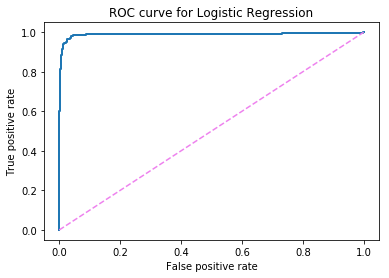

In [80]:
roc_auc(lr3, "Logistic Regression", y_val_3, X_val_3)

<Figure size 720x504 with 0 Axes>

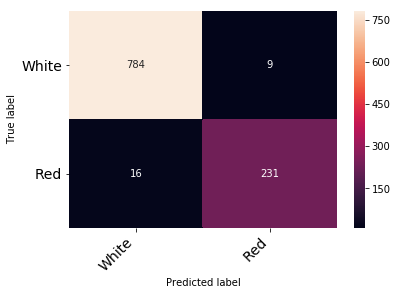

<Figure size 720x504 with 0 Axes>

In [81]:
#Confusion matrix for whole training and val in training set
lr_cm_3 = confusion_matrix(y_val_3, lr_pred3)
print_confusion_matrix(lr_cm_3)

**Observations**:
- Still not predicting as many as using all of the features
- Try including more features but not all

In [82]:
append_to_lists(y_val_3, lr_pred3, lr_predprob3, "Logistic Regression, Top 6 features")

### Logistic Regression with more features (importance >0.1%)
- Include some more features - those with higher than 0.1% importance

In [83]:
second_most_important = [k for k,v in importance.items() if v > 0.001]
print(f"Second Most important features:\n{second_most_important}")

Second Most important features:
['fixed_acidity', 'volatile_acidity', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'free_percentage']


In [84]:
# Re-define data 
X_4 = wine[second_most_important]
y_4 = wine['predictor']

X_train_4, X_hold_out_4, y_train_4, y_hold_out_4 = train_test_split(X_4, y_4, test_size=.20, random_state=rs)
X_train_4, X_val_4, y_train_4, y_val_4 = train_test_split(X_train_4, y_train_4, test_size=.20, random_state=rs)

In [85]:
# Logistic Regression and Cross Validation
lr4 = LogisticRegression(random_state=rs).fit(X_train_4, y_train_4)
lr_predprob4 = lr4.predict_proba(X_val_4)
lr_pred4 = lr4.predict(X_val_4)

lr_cv_4 = LogisticRegressionCV(random_state=rs).fit(X_train_4, y_train_4)
lr_cv_predprob_4 = lr_cv_4.predict_proba(X_val_4)
lr_cv_pred_4 = lr_cv_4.predict(X_val_4)

In [86]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val_4, lr_pred4, X_train_4, y_train_4)

'Accuracy: 0.983 CV:0.986\n    Precision: 0.979 CV:0.979\n    Recall: 0.947 CV:0.965\n    F1: 0.963 CV: 0.972'

ROC AUC score =  0.993082181639957


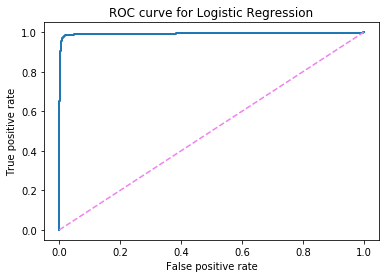

In [87]:
roc_auc(lr4, "Logistic Regression", y_val_4, X_val_4)

<Figure size 720x504 with 0 Axes>

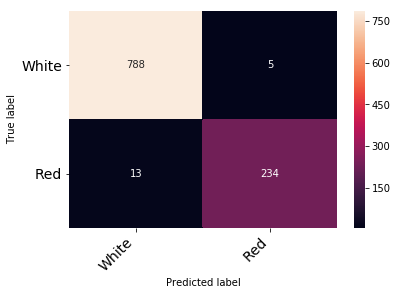

<Figure size 720x504 with 0 Axes>

In [88]:
#Confusion matrix for whole training and val in training set
lr_cm_4 = confusion_matrix(y_val_4, lr_pred4)
print_confusion_matrix(lr_cm_4)

In [89]:
append_to_lists(y_val_4, lr_pred4, lr_predprob4, "Logistic Regression, Top 10 features")

### Logistic Regression - Remove most dominant features
- As these have a really strong correlation with the wine colour, wanted to remove them from the dataset to evaluate what effect this may have on the model.

In [90]:
# Re-define data 
X_5 = wine.drop(['total_sulfur_dioxide', 'chlorides', 'predictor'], axis=1)
y_5 = wine['predictor']

X_train_5, X_hold_out_5, y_train_5, y_hold_out_5 = train_test_split(X_5, y_5, test_size=.20, random_state=rs)
X_train_5, X_val_5, y_train_5, y_val_5 = train_test_split(X_train_5, y_train_5, test_size=.20, random_state=rs)

In [92]:
# Logistic Regression and Cross Validation
lr_cv_5 = LogisticRegressionCV(random_state=rs).fit(X_train_5, y_train_5)
lr_cv_predprob_5 = lr_cv_5.predict_proba(X_val_5)
lr_cv_pred_5 = lr_cv_5.predict(X_val_5)

lr5 = LogisticRegression(random_state=rs).fit(X_train_5, y_train_5)
lr_predprob5 = lr5.predict_proba(X_val_5)
lr_pred5 = lr5.predict(X_val_5)

In [93]:
# Check Error Metrics, ROC and Confusion Matrix
log_reg_errors(y_val_5, lr_pred5, X_train_5, y_train_5)

'Accuracy: 0.982 CV:0.986\n    Precision: 0.983 CV:0.978\n    Recall: 0.939 CV:0.965\n    F1: 0.961 CV: 0.971'

ROC AUC score =  0.992418479509473


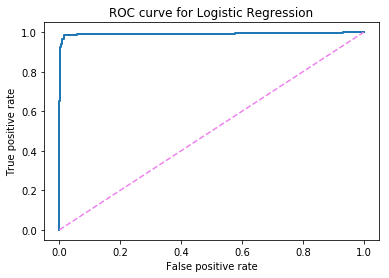

In [94]:
roc_auc(lr_cv_5, "Logistic Regression", y_val_5, X_val_5)

<Figure size 720x504 with 0 Axes>

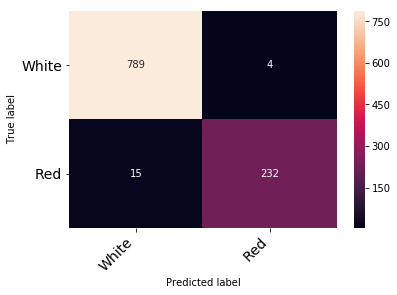

<Figure size 720x504 with 0 Axes>

In [95]:
lr5_cm = confusion_matrix(y_val_5, lr_pred5)
print_confusion_matrix(lr5_cm)

**Observations:**
- Still performs really well with 98% accuracy and 98% precision
- Other features are still telling of the wine colour 
- Fewer misclassifications in of red samples

In [98]:
append_to_lists(y_val_5, lr_pred5, lr_predprob5, 'Log Reg - no important features')

### KNN - using all features
- Trying a K Nearest neighbour algorithm on the dataset, will try a variety of number of neighbours to see which performs best based on accuracy

In [99]:
# Re define data
Xk = wine.drop('predictor', axis=1)
yk = wine['predictor']

Xk_train, Xk_hold_out, yk_train, yk_hold_out = train_test_split(Xk, yk, test_size=.20, random_state=rs)
Xk_train, Xk_val, yk_train, yk_val = train_test_split(Xk_train, yk_train, test_size=.20, random_state=rs)

In [100]:
# Find best K
k = list(range(1, 12))
scores = []

for i in k:
    KNN = KNeighborsClassifier(n_neighbors=i)
    KNN.fit(Xk_train, yk_train)
    y_pred_knn = KNN.predict(Xk_val)
    score = f1_score(yk_val, y_pred_knn)
    scores.append(score)

total_scores = dict(zip(k, scores)) # Create dictionary of scores and number of neighbours 
best_k = ([k for k,v in total_scores.items() if v == max(scores)]) # find k with highest accuracy

print(f"K with highest accuracy score = {best_k}")

K with highest accuracy score = [1]


In [101]:
KNN = KNeighborsClassifier(n_neighbors=best_k[0])
KNN.fit(Xk_train, yk_train)
y_pred_knn = KNN.predict(Xk_val)
y_predprob_knn = KNN.predict_proba(Xk_val)

In [102]:
ModelErrors(KNN, Xk_train, yk_train, 'K Nearest Neighbour')

K Nearest Neighbour Av Accuracy: 0.934
K Nearest Neighbour Av Precision: 0.864
K Nearest Neighbour Av Recall: 0.867
K Nearest Neighbour Av F1: 0.866


ROC AUC score =  0.9155439038959314


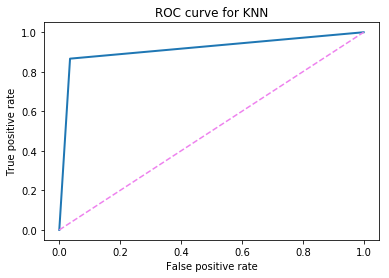

In [103]:
roc_auc(KNN, "KNN", yk_val, Xk_val)

<Figure size 720x504 with 0 Axes>

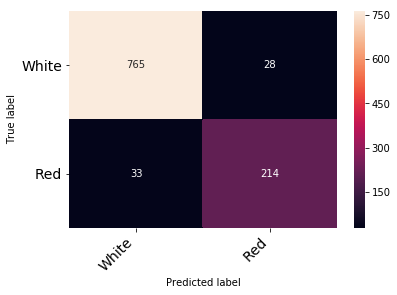

<Figure size 720x504 with 0 Axes>

In [104]:
knn_cm = confusion_matrix(yk_val, y_pred_knn)
print_confusion_matrix(knn_cm)

**Observations:**
- Incorrectly predicting over 60 wines
- Lower recall and F1 Scores

In [105]:
append_to_lists(yk_val, y_pred_knn, y_predprob_knn, "K Nearest Neighbours, all features")

### Random Forest - All features
- Random Forests have the tendency to overfit and have a lot of parameters to tune

In [106]:
Xrf = wine.drop('predictor', axis=1)
yrf = wine['predictor']

Xrf_train, Xrf_hold_out, yrf_train, yrf_hold_out = train_test_split(Xrf, yrf, test_size=.20, random_state=rs)

In [107]:
Xrf_train, Xrf_val, yrf_train, yrf_val = train_test_split(Xrf_train, yrf_train, test_size=.20, random_state=rs)

In [112]:
RFC = RandomForestClassifier(n_estimators=20, max_depth=3, random_state=rs) #random parameters - can use gridsearch or randomsearch
RFC.fit(Xrf_train, yrf_train)
y_pred_rfc_proba = RFC.predict_proba(Xrf_val)
y_pred_rfc = RFC.predict(Xrf_val)

In [117]:
ModelErrors(RFC, Xrf_train, yrf_train, 'Random Forest')

Random Forest Av Accuracy: 0.986
Random Forest Av Precision: 0.989
Random Forest Av Recall: 0.955
Random Forest Av F1: 0.972


ROC AUC score =  0.9953848653902175


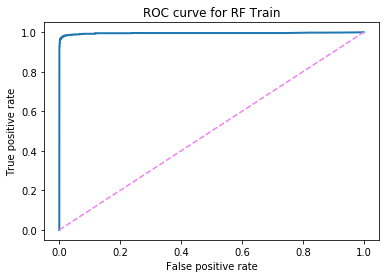

In [113]:
roc_auc(RFC, "RF Train", yrf_train, Xrf_train)

ROC AUC score =  0.9911855251670745


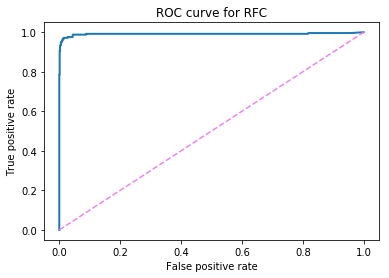

In [114]:
roc_auc(RFC, "RFC", yrf_val, Xrf_val)

<Figure size 720x504 with 0 Axes>

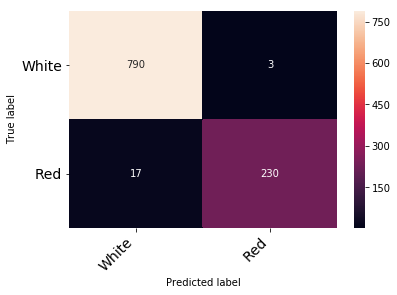

<Figure size 720x504 with 0 Axes>

In [115]:
rfc_cm = confusion_matrix(yrf_val, y_pred_rfc)
print_confusion_matrix(rfc_cm)

In [116]:
append_to_lists(yrf_val, y_pred_rfc, y_pred_rfc_proba, "Random Forest, all features")

**Observations**:
- Very few red predicted incorrectly. 
- Still little error, but no huge improvements from earlier models

## Evaluate Models

### Assess incorrect predictions
- Creating a dictionary of models and number of incorrect predictions - to show models with highest accuracy

In [118]:
incorrect_pred_dict = dict(zip(model_name, incorrect_predictions))
incorrect_pred_dict

{'Log Reg, all features': 19,
 'Decision Tree, all features': 21,
 'Logistic Regression, Top 2 features': 71,
 'Logistic Regression, Top 6 features': 25,
 'Logistic Regression, Top 10 features': 18,
 'Log Reg - no important features': 19,
 'K Nearest Neighbours, all features': 61,
 'Random Forest, all features': 20}

- Logistic Regression with top 10 features is the best performing model
- Logistic Regression all features = Simplest Model
- Random Forest performs well but could overfit
- Not a lot of error improvement between logistic regression models with feature engineering
- Check if the same incorrect predictions are coming up with the rest of the models

In [123]:
# Compare across models to see which predictions are constantly predicted incorrectly compared to Log Reg 
no_of_same = []
for i in list_of_incorrects:
    no_of_same.append(len(set(incorrect_rows(y_val, lr_pred)).intersection(i)))

In [124]:
same_incorrects = dict(zip(model_name, no_of_same))
same_incorrects

{'Log Reg, all features': 19,
 'Decision Tree, all features': 6,
 'Logistic Regression, Top 2 features': 14,
 'Logistic Regression, Top 6 features': 12,
 'Logistic Regression, Top 10 features': 18,
 'Log Reg - no important features': 18,
 'K Nearest Neighbours, all features': 9,
 'Random Forest, all features': 9}

**Observations:**
- For logistic regression models the same features seem to be consistently incorrectly predicted. 
- KNN, Descision Trees & Random Forest seem to be predicting different features incorrectly - therefore ensembling models may be the answer.

In [125]:
# Check mean values of features in full dataset and incorrectly predicted dataframe for Log Reg (All features)
wine.groupby('predictor').mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_percentage
predictor,,,,,,,,,,,,
0,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,25.557613
1,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,38.231088


In [126]:
# Create dataframe of just incorrect predictions to observe any deviations from full dataset mean
logregall_incorrect_df = incorrect_df(y_val, lr_pred, lr_predprob, wine)

logregall_incorrect_df.groupby('predictor').mean()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_percentage,white_prob,red_prob
predictor,,,,,,,,,,,,,,
0,6.340000,0.597000,0.194000,1.44,0.038600,16.600000,69.200000,0.992364,3.262000,0.438,10.520000,32.066,0.241360,0.758640
1,6.735714,0.454286,0.270714,2.90,0.069357,32.892857,113.214286,0.994761,3.358571,0.615,11.135714,30.605,0.692693,0.307307


**Observations:**
- Full dataset: Mean Total Sulphur Dioxide for White (0) is much higher than those in incorrect predictions. Opposite for Red (1), therefore may be big predictor for incorrect samples. 
- Lower residual sugar mean in incorrect predictions.
- Free sulphur dioxide means approximately reversed for incorrect predictions.
- Little differences in alcohol, sulphates, pH, chlorides

### Voting Classifer on Logistic Regression & Random Forest
- Trying a voting classifier using logistic regression and random forest models to try and reduce the number of misclassifications as these models seem to incorrectly predicting different samples. May be able to catch some of these samples by one model or the other.

In [127]:
# Redefine Data
X_vote = wine.drop('predictor', axis=1)
y_vote = wine['predictor']

X_train_vote, X_hold_out_vote, y_train_vote, y_hold_out_vote = train_test_split(X_vote, y_vote, test_size=.20, random_state=rs)
X_train_vote, X_val_vote, y_train_vote, y_val_vote = train_test_split(X_train_vote, y_train_vote, test_size=.20, random_state=rs)

In [128]:
clf1 = LogisticRegression(random_state=rs) # classifier 1 = log reg
clf2 = RandomForestClassifier(n_estimators=10, random_state=rs) # classifer 2 = random forest

### Hard Voting - Uses predicted class labels for majority rule voting

In [130]:
# Hard voting - uses predicted class labels for majority rule voting
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)], voting='hard')
eclf1 = eclf1.fit(X_train_vote, y_train_vote)
eclf_pred = eclf1.predict(X_val)

<Figure size 720x504 with 0 Axes>

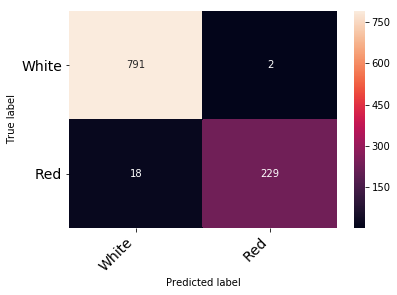

<Figure size 720x504 with 0 Axes>

In [131]:
votehard_cm = confusion_matrix(y_val_vote, eclf_pred)
print_confusion_matrix(votehard_cm)

### Soft Voting - Predicts class label based on argmax of the sums of the predicted probabilities

In [133]:
eclf2 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)], voting='soft')
eclf2 = eclf2.fit(X_train_vote, y_train_vote)
eclf2_pred = eclf2.predict(X_val)
eclf2_pred_proba = eclf2.predict_proba(X_val)

ROC AUC score =  0.997998682806541


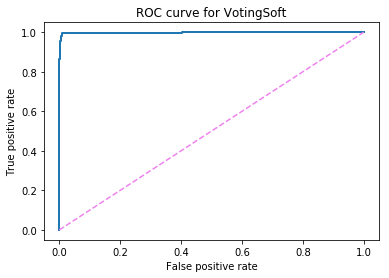

In [134]:
roc_auc(eclf2, "VotingSoft", y_val_vote, X_val_vote)

<Figure size 720x504 with 0 Axes>

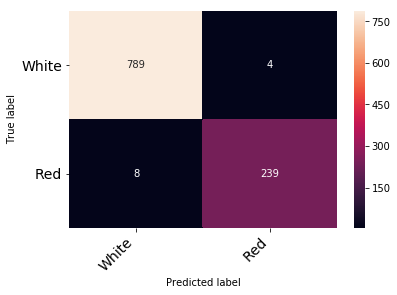

<Figure size 720x504 with 0 Axes>

In [135]:
votesoft_cm = confusion_matrix(y_val_vote, eclf2_pred)
print_confusion_matrix(votesoft_cm)

### Weighted Voting

In [136]:
eclf3 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2)],voting='soft', weights=[5,1], flatten_transform=True)
eclf3 = eclf3.fit(X_train_vote, y_train_vote)
eclf3_pred = eclf2.predict(X_val)

ROC AUC score =  0.99728392666602


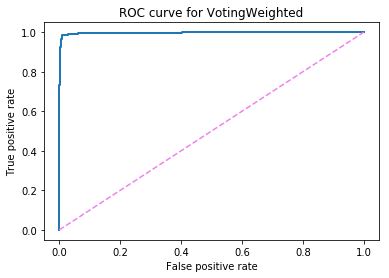

In [137]:
roc_auc(eclf3, "VotingWeighted", y_val_vote, X_val_vote)

<Figure size 720x504 with 0 Axes>

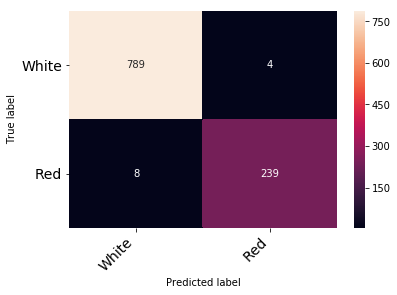

<Figure size 720x504 with 0 Axes>

In [138]:
voteweight_cm = confusion_matrix(y_val_vote, eclf3_pred)
print_confusion_matrix(voteweight_cm)

**Observations:**
- Both soft voting and weighted voting reduce the number of incorrect predictions to just 8.
- Soft voting is easier to interpret as a weighted voting classifier's parameters can be altered more

## Run Model on Test Data

### Most Effective: Soft Voting Logistic Regression & Random Forest

In [139]:
vote_final_prediction = eclf2.predict(X_hold_out)
vote_final_prediction_proba = eclf2.predict_proba(X_hold_out)

ROC AUC score =  0.9987917072300357


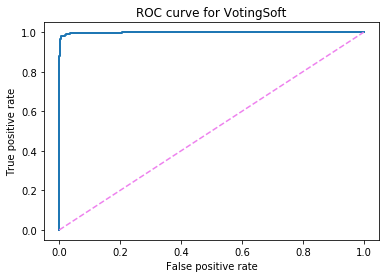

In [140]:
roc_auc(eclf2, "VotingSoft", y_hold_out, X_hold_out)

<Figure size 720x504 with 0 Axes>

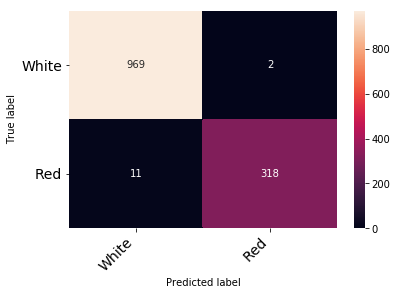

<Figure size 720x504 with 0 Axes>

In [141]:
votesoftfinal_cm = confusion_matrix(y_hold_out, vote_final_prediction)
print_confusion_matrix(votesoftfinal_cm)

In [144]:
ModelErrors(eclf2, X_hold_out, y_hold_out, 'Final Soft Voting')

Final Soft Voting Av Accuracy: 0.985
Final Soft Voting Av Precision: 0.994
Final Soft Voting Av Recall: 0.948
Final Soft Voting Av F1: 0.97


### Simplest Model: Logistic Regression

In [145]:
logreg_prediction = lr.predict(X_hold_out)

ROC AUC score =  0.9943999073433524


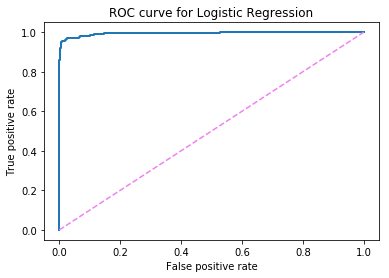

In [146]:
roc_auc(lr, "Logistic Regression", y_hold_out, X_hold_out)

<Figure size 720x504 with 0 Axes>

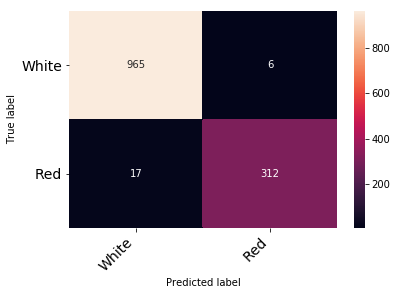

<Figure size 720x504 with 0 Axes>

In [147]:
lrfinal_cm = confusion_matrix(y_hold_out, logreg_prediction)
print_confusion_matrix(lrfinal_cm)

In [148]:
ModelErrors(lr, X_hold_out, y_hold_out, 'Final Log Regression')

Final Log Regression Av Accuracy: 0.967
Final Log Regression Av Precision: 0.962
Final Log Regression Av Recall: 0.906
Final Log Regression Av F1: 0.933


## Tableau Dashboard Prep 
- Wanted to create a Tableau dashboard to look further into the missclassified samples and analyse their characteristics in comparison to other samples.
- Create dataframe of test data with details of model prediction.
- Using the Voting Classifier as this was best performing model.

In [150]:
# Change Predictor column back to Red and White for visuals
# Create predictor column (Y) and drop text column of wine colors: 
def wine_type(number):
    '''Changes predictor value to typ again
    White = 0
    Red = 1'''
    
    if number == 0:
        return "White"
    if number == 1:
        return "Red"

wine["colour"] = wine["predictor"].apply(wine_type)
wine.drop("predictor", axis=1, inplace=True)

In [151]:
# Make test data frame
test_data = pd.concat([X_hold_out, pd.DataFrame(y_hold_out)], axis=1, sort=False)
test_data["colour"] = test_data["predictor"].apply(wine_type)
test_data.drop("predictor", axis=1, inplace=True)

# Make dataframe of incorrect predictions 
votes_incorrect = incorrect_df(y_hold_out, vote_final_prediction, vote_final_prediction_proba, wine)

# Add incorrect column on to predicted dataframe
votes_incorrect["model_prediction"] = "incorrect"

# Add to test dataframe
full_data = pd.concat([test_data, votes_incorrect], axis=1, sort=False)

# Change NaNs in prediction column to Correct
full_data.model_prediction = full_data.model_prediction.fillna('correct')

# Drop rest of the columns 
full_data.dropna(axis=1, inplace=True)

# Add sample number column
full_data["sample_number"] = range(1, len(full_data)+1)

#save dataframe as csv
full_data.to_csv('full_data.csv', index=False)

In [153]:
# Full test data set with details on model prediction
full_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,free_percentage,colour,model_prediction,sample_number
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,32.35,Red,correct,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,16.67,Red,correct,2
13,7.8,0.61,0.29,1.6,0.114,9.0,29.0,0.9974,3.26,1.56,9.1,31.03,Red,correct,3
14,8.9,0.62,0.18,3.8,0.176,52.0,145.0,0.9986,3.16,0.88,9.2,35.86,Red,correct,4
20,8.9,0.22,0.48,1.8,0.077,29.0,60.0,0.9968,3.39,0.53,9.4,48.33,Red,correct,5


---

**Why are Sulphur Dioxide & Chlorides such important features in defining wine colour?** 

Sulphur Dioxide acts as a preservative within wine due to its anti-oxidative and anti-microbial properties. The total amount of sulphur dioxide is generally higher in white wine than red, as there are fewer tannins, which also act as a preservative. Tannins are found in the grape skins and seeds, which are greatly reduced in white wine as they are not typically fermented with their skins or seeds, unlike red. It’s not uncommon for sulphur dioxide to be added to the wine in the making process to ensure preservation. Similarly, higher chloride levels are found in red wines, due to the presence of chlorides in the skin and seeds. Minerals are stored in the skin and seeds after been absorbed from the soil through the vine, therefore varies across wine from different regions.